## Load necessary libraries

In [1]:
#!pip install transformers
#!pip install tensorflow
#!pip install biopython

In [1]:
import pickle 
embeddings, labels, seq_ids = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_embeddings.b_average", "rb"))

In [2]:
import numpy as np
neg, pos = np.unique(labels, return_counts=True)[1]

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, random_state=42, test_size=0.1)

In [11]:
weight_for_0 = (1 / neg) * (len(labels) / 2.0)
weight_for_1 = (1 / pos) * (len(labels) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [70]:
import tensorflow as tf
import keras
import numpy as np
nn = keras.models.Sequential()
nn.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(768,1)))
nn.add(keras.layers.MaxPooling1D(pool_size=2))
nn.add(keras.layers.Flatten())
nn.add(keras.layers.Dense(units=128, activation='relu'))
nn.add(keras.layers.Dropout(0.5)) 
nn.add(keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.AdamW(), metrics=['binary_accuracy'], weighted_metrics=['binary_accuracy'])

nn.fit(X_train, np.array(y_train), epochs=10, batch_size=16, validation_data=(X_test, y_test), class_weight=class_weight, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
5618/5618 [==============================] - 16s 3ms/step - loss: 0.4700 - binary_accuracy: 0.7852 - weighted_binary_accuracy: 0.7852 - val_loss: 0.4345 - val_binary_accuracy: 0.7988 - val_weighted_binary_accuracy: 0.7988
Epoch 2/10
5618/5618 [==============================] - 15s 3ms/step - loss: 0.4458 - binary_accuracy: 0.7962 - weighted_binary_accuracy: 0.7962 - val_loss: 0.4191 - val_binary_accuracy: 0.8043 - val_weighted_binary_accuracy: 0.8043
Epoch 3/10
5618/5618 [==============================] - 15s 3ms/step - loss: 0.4368 - binary_accuracy: 0.8025 - weighted_binary_accuracy: 0.8025 - val_loss: 0.4205 - val_binary_accuracy: 0.8120 - val_weighted_binary_accuracy: 0.8120
Epoch 4/10
5618/5618 [==============================] - 15s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8048 - weighted_binary_accuracy: 0.8048 - val_loss: 0.4225 - val_binary_accuracy: 0.8084 - val_weighted_binary_accuracy: 0.8084
Epoch 5/10
5618/5618 [==============================] - 14s 3ms/step

: 

In [69]:
nn.save('CNN_BERT_pool_model')

INFO:tensorflow:Assets written to: CNN_BERT_pool_model/assets


INFO:tensorflow:Assets written to: CNN_BERT_pool_model/assets


## Run predictions on test set 

In [7]:
test_embeddings, test_labels, seq_ids = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_embeddings_TEST.b_average", "rb"))

In [8]:
#test_embeddings, test_labels = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/Superfamily/BERT/LTRBERT_superfamily_classifier_embeddings_TEST.b_average", "rb"))
predictions = nn.predict(test_embeddings)
pred = np.array([1 if x > 0.5 else 0 for x in predictions])

1823/1823 [==============================] - 2s 844us/step


In [9]:
np.array([1 if x > 0.5 else 0 for x in nn.predict(test_embeddings)])

1823/1823 [==============================] - 2s 823us/step


array([1, 1, 1, ..., 0, 0, 0])

In [10]:
from sklearn.metrics import classification_report

classification_report(np.array(test_labels), np.array([1 if x > 0.5 else 0 for x in nn.predict(test_embeddings)]), output_dict=True)

1823/1823 [==============================] - 1s 802us/step


{'0': {'precision': 0.92022433882899,
  'recall': 0.8302652242191589,
  'f1-score': 0.8729332446625542,
  'support': 22924.0},
 '1': {'precision': 0.8965847176079734,
  'recall': 0.9533687542392042,
  'f1-score': 0.9241052472982784,
  'support': 35384.0},
 'accuracy': 0.9049701584688208,
 'macro avg': {'precision': 0.9084045282184817,
  'recall': 0.8918169892291816,
  'f1-score': 0.8985192459804163,
  'support': 58308.0},
 'weighted avg': {'precision': 0.905878719749542,
  'recall': 0.9049701584688208,
  'f1-score': 0.9039867903383185,
  'support': 58308.0}}

In [11]:
import pandas as pd
import Bio.SeqIO as SeqIO
max_len=512
#seq_ids = [rec.id for rec in long_sequences]
pd.DataFrame({"ID": seq_ids, "actual": test_labels, "pred": pred}).to_csv("test_predictions.csv", index=False)

[Text(0, 0, 'F1:\n0.82'), Text(0, 0, 'F1:\n0.84'), Text(0, 0, 'F1:\n0.90')]

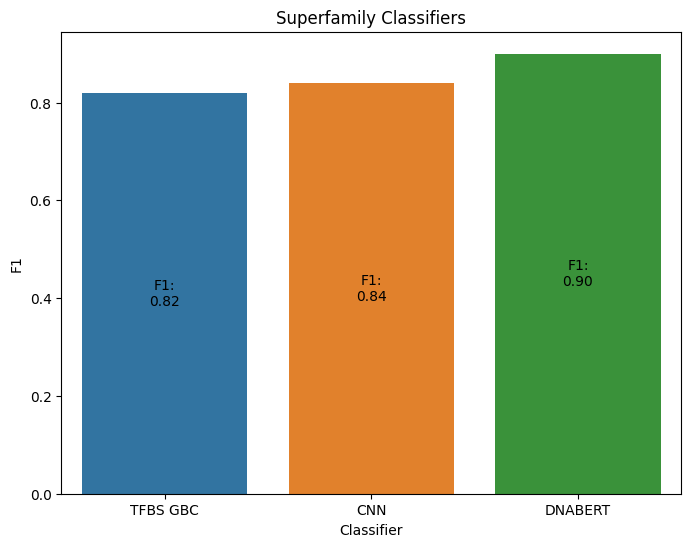

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(8, 6),dpi=100)

Superfam = pd.DataFrame({"F1": [0.82,0.84,0.9], "Classifier": ["TFBS GBC","CNN","DNABERT"]})
g = sns.barplot(x="Classifier", y="F1", data=Superfam, ax=ax)
g.set_title("Superfamily Classifiers")
ax.bar_label(ax.containers[-1], fmt='F1:\n%.2f', label_type='center')

[Text(0, 0, 'F1:\n0.89'), Text(0, 0, 'F1:\n0.75'), Text(0, 0, 'F1:\n0.89')]

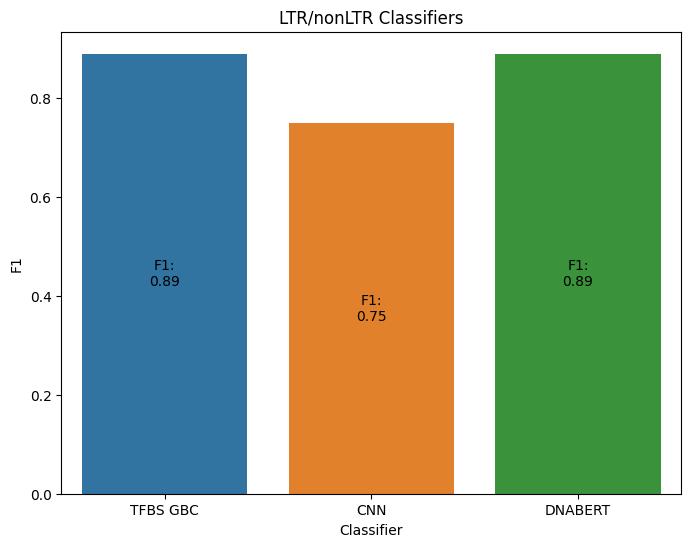

In [33]:
fig, ax = plt.subplots(figsize=(8, 6),dpi=100)

Superfam = pd.DataFrame({"F1": [0.89,0.75,0.89], "Classifier": ["TFBS GBC","CNN","DNABERT"]})
g = sns.barplot(x="Classifier", y="F1", data=Superfam, ax=ax)
g.set_title("LTR/nonLTR Classifiers")
ax.bar_label(ax.containers[-1], fmt='F1:\n%.2f', label_type='center')

## Load the models and move to GPU if available

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pickle
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('zhihan1996/DNA_bert_6')
model = BertForSequenceClassification.from_pretrained('xhorvat9/LTRBERT_LTR_classifier_512', num_labels=2)

if torch.cuda.is_available():    

    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model.to(device)


ModuleNotFoundError: No module named 'torch'

## Create necessary helper function with overloaded dataset class

In [4]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# write helper functions for tokenizing data
 # the kmer splitting function|
 
def Kmers_funct(seq, size=6):
   return [seq[x:x+size].upper() for x in range(len(seq) - size + 1)]
def tok_func(x): return " ".join(Kmers_funct(x.replace("N","")))


class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

ModuleNotFoundError: No module named 'torch'

## Load the sequences and draw predictions for sliding window using BERT

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import Bio.SeqIO as SeqIO
from sklearn.model_selection import train_test_split
import random
sequences = [str(rec.seq) for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/train_LTRs.fasta","fasta")]

max_len = 512
n_sequences = len(sequences)

generated, genomic, markov = int(n_sequences*0.15), int(n_sequences*0.6), int(n_sequences*0.25)

genomic_non_LTRs = [rec for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/non_LTRs_training_genomic_extracts.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0]
if genomic < len(genomic_non_LTRs):
    genomic_non_LTRs = random.sample(genomic_non_LTRs, genomic)
generated_non_LTRs = [rec for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/non_LTRs_training_generated.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0]
if generated < len(generated_non_LTRs):
    generated_non_LTRs = random.sample(generated_non_LTRs, generated)
markov_non_LTRs = [rec for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/non_LTRs_training_markovChain.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0]
if markov < len(markov_non_LTRs):
    markov_non_LTRs = random.sample(markov_non_LTRs, markov)
non_LTRs = genomic_non_LTRs + generated_non_LTRs + markov_non_LTRs

non_LTRs = [str(rec.seq) for rec in non_LTRs]

long_sequences = sequences + non_LTRs
labels = np.array([1] * len(sequences) + [0]* len(non_LTRs))

X_train, X_test, y_train, y_test = train_test_split(long_sequences, labels, random_state=42, test_size=0.3)

In [6]:
from transformers import Trainer
import random
import tqdm
window_size = max_len
stride = max_len//3 # ~ 1/3 of window size
model.to(device)
outputs = []
sequences = []
for seq in X_train:
  seq_windows = []
  for i in range(0, len(seq), stride):
      start = i
      end = i + window_size

      if end > len(seq):
        end = len(seq)
      seq_windows.append(seq[start:end])
  sequences.append(seq_windows)

#sequences = random.sample(sequences, 30)

# Get the embeddings for the last layer and a specific token (e.g., the first token)
layer_index = -1  # Index of the last layer
token_index = 0   # Index of the token you're interested in
model_embeddings = []
model.eval()
for s in tqdm.tqdm(sequences):
  tokenized_segment = tokenizer([tok_func(sequence_segment) for sequence_segment in s], padding=True, truncation=True, max_length=max_len, return_tensors="pt")
  tokenized_segment.to(device)
  with torch.no_grad():
      outputs = model(**tokenized_segment, output_hidden_states=True)
      hidden_states = outputs.hidden_states
      embeddings = hidden_states[layer_index][:, token_index, :]
      embeddings = embeddings.to('cpu')
      model_embeddings.append(embeddings)
  #test_dataset = Dataset(X_test_tokenized); # Load trained model
  #test_trainer = Trainer(model); # Make prediction
  #output, _,_ = test_trainer.predict(test_dataset); # Preprocess raw predictions
  #outputs.append(output)

  0%|          | 165/163229 [00:11<3:15:35, 13.90it/s]


KeyboardInterrupt: 

In [4]:
import pickle
model_embeddings = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_embeddings.b", "rb"))

## Train the CNN on BERT embeddings

In [5]:
import tensorflow as tf
import keras
nn = keras.models.Sequential()
nn.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
nn.add(keras.layers.MaxPooling1D(pool_size=2))
nn.add(keras.layers.Flatten())
nn.add(keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3


2023-10-15 09:03:43.985312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-15 09:03:44.102402: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-15 09:03:44.198721: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-15 09:03:44.754719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5c8c9e8c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 09:03:44.754787: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 7g.80gb, Compute Capability 8.0
2023-10-15 09:03:44.760169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 09:03:44.905978: I ./tensorflow/compiler/jit/d

4591/4591 [==============================] - 13s 2ms/step - loss: 0.2363 - accuracy: 0.9019 - val_loss: 0.2182 - val_accuracy: 0.9128
Epoch 2/3
4591/4591 [==============================] - 10s 2ms/step - loss: 0.2197 - accuracy: 0.9103 - val_loss: 0.2122 - val_accuracy: 0.9134
Epoch 3/3
4591/4591 [==============================] - 10s 2ms/step - loss: 0.2124 - accuracy: 0.9130 - val_loss: 0.2075 - val_accuracy: 0.9150


In [3]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 383, 1)  # Adjust the input size based on your data shape

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.sigmoid(x)  # Sigmoid activation for binary classification
        return x

# Instantiate the model
model = CustomModel()

# Define the loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters())

# Print the model architecture
print(model)


CustomModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=12256, out_features=1, bias=True)
)


In [9]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset( torch.tensor(X_train),  torch.tensor(y_train))
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Make predictions
model.eval()
test_data = TensorDataset( torch.tensor(X_test),  torch.tensor(y_test))
with torch.no_grad():
    # Example input for prediction
    input_for_prediction = torch.Tensor(test_data) 
    prediction = model(input_for_prediction)

print("Prediction:", prediction.item())

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [32, 1, 3], but got 2-dimensional input of size [32, 768] instead

In [ ]:

linear_nn = keras.models.Sequential()
linear_nn.add(keras.layers.Dense(512, activation='relu', input_shape=(768, 1)))
linear_nn.add(keras.layers.Dropout(0.5))
linear_nn.add(keras.layers.Dense(512, activation='relu', input_shape=(768, 1)))
linear_nn.add(keras.layers.Dense(units=1, activation='sigmoid', input_shape=(768, 1)))

linear_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

linear_nn.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1)

In [22]:
import random
window_size = max_len
stride = max_len//3 # ~ 1/3 of window size
model.to(device)
outputs = []
sequences = []
for seq in X_test:
  seq_windows = []
  for i in range(0, len(seq), stride):
      start = i
      end = i + window_size

      if end > len(seq):
        end = len(seq)
      seq_windows.append(seq[start:end])
  sequences.append(seq_windows)

seq_ids = random.sample(range(len(sequences)), 3500)
sequences = [sequences[i] for i in seq_ids]
labels = [y_test[i] for i in seq_ids]
# Get the embeddings for the last layer and a specific token (e.g., the first token)
layer_index = -1  # Index of the last layer
token_index = 0   # Index of the token you're interested in
validation_embeddings = []
model.eval()
for s in tqdm.tqdm(sequences):
  tokenized_segment = tokenizer([tok_func(sequence_segment) for sequence_segment in s], padding=True, truncation=True, max_length=max_len, return_tensors="pt")
  tokenized_segment.to(device)
  with torch.no_grad():
      outputs = model(**tokenized_segment, output_hidden_states=True)
      hidden_states = outputs.hidden_states
      embeddings = hidden_states[layer_index][:, token_index, :]
      embeddings = embeddings.to('cpu')
      validation_embeddings.append(embeddings)

100%|██████████| 3500/3500 [01:46<00:00, 32.96it/s]


In [23]:
inp = []
for emb in tqdm.tqdm(validation_embeddings):
    inp.append((sum(emb)/len(emb)).numpy())
inp = np.array(inp)

100%|██████████| 3500/3500 [00:00<00:00, 44513.37it/s]


In [8]:
import numpy as np
nn.evaluate(X_test, np.array(y_test))

2187/2187 [==============================] - 3s 1ms/step - loss: 0.2096 - accuracy: 0.9146


[0.20959198474884033, 0.9145891666412354]

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(y_test), (nn.predict(X_test) > 0.5).astype(int).flatten())

2187/2187 [==============================] - 2s 911us/step


array([[24215,  3387],
       [ 2588, 39766]])

In [11]:
from sklearn.metrics import f1_score
f1_score(np.array(y_test), (nn.predict(X_test) > 0.5).astype(int).flatten())

2187/2187 [==============================] - 2s 918us/step


0.9301226800145018

### Run on test set

In [ ]:
window_size = 350
stride = 116 # ~ 1/3 of window size

outputs = []
sequences = []
for seq in X_test:
  seq_windows = []
  for i in range(0, len(seq), stride):
      start = i
      end = i + window_size

      if end > len(seq):
        end = len(seq)
      seq_windows.append(seq[start:end])
  sequences.append(seq_windows)

counter = 0
for s in sequences:
  if counter % 500 == 0 and counter != 0:
    print(f"processing sequence {counter}")
  X_test_tokenized = tokenizer([tok_func(x) for x in s], padding=True, truncation=True, max_length=350) # Create torch dataset
  test_dataset = Dataset(X_test_tokenized) # Load trained model
  test_trainer = Trainer(model) # Make prediction
  output, _,_ = test_trainer.predict(test_dataset) # Preprocess raw predictions
  outputs.append(output)

In [ ]:
i = tf.keras.preprocessing.sequence.pad_sequences(outputs, padding="pre", maxlen=45, dtype='float32')
score = nn.evaluate(i, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.4219169020652771
Test accuracy: 0.8043588399887085


In [ ]:
nn.save('/content/drive/MyDrive/sequences/BERT_pooling_CNN/TF_CNN_BERT_pool_model')

### Visualize filters to check for influential regions


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/sequences/BERT_pooling_CNN/TF_CNN_BERT_pool_model')

filters, biases = new_model.layers[0].get_weights()

In [ ]:
f = abs(filters)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, filters.shape[-1], figsize=(25, 10))
for i in range(filters.shape[-1]):
    im = axs[i].imshow(f[:, :, i], cmap="gray")
    axs[i].axis('off')
plt.show()